<a href="https://colab.research.google.com/github/IANGECHUKI176/deeplearning/blob/main/pytorch/nlp/karpathy/micrograd_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random
%matplotlib inline


In [ ]:
def f(x):
    return 3*x**2 - 4*x + 5

In [ ]:
f(3.0)

20.0

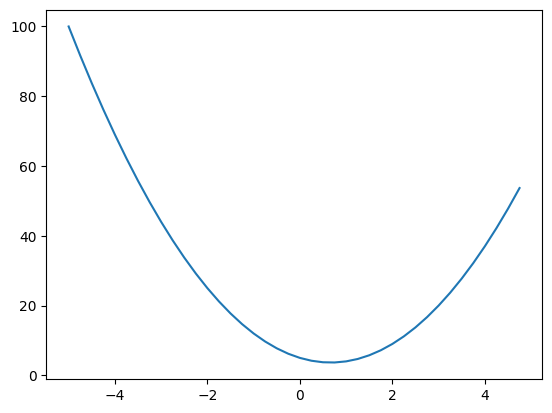

In [ ]:
x5 = np.arange(-5,5,0.25)
y5 = f(x5)
plt.plot(x5,y5)

In [ ]:
h= 0.0000001
x= 2/3
(f(x+h) - f(x) )/ h

2.9753977059954195e-07

In [ ]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c

print(d)

4.0


In [ ]:
h = 0.0001

#inputs
a = 2.0
b = -3.0
c = 10.0
d1 = a*b + c
c += h
d2 = a*b + c

print('d1',d1)
print('d2',d2)
print('slope',(d2-d1)/h)


d1 4.0
d2 4.0001
slope 0.9999999999976694


In [ ]:
class Value:
    def __init__(self,data,_children=(),_op="",label=""):
        self.data = data
        self.grad = 0.0
        self._backward = lambda : None
        self._prev = set(_children)
        self._op = _op
        self.label=label


    def __pow__(self,other):
        assert isinstance(other,(int,float)) , "only supports ints and floats for now"
        out = Value(self.data ** other,(self,),f"**{other}")
        def _backward():
            self.grad += other * (self.data ** (other-1)) * out.grad
        out._backward = _backward
        return out

    def __add__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data + other.data,(self,other),"+")
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out

    def __mul__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data * other.data,(self,other),"*")
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out


    def __repr__(self):
        return f"Value(data={self.data})"

    def __truediv__(self,other):#self / other
        return self * other ** -1

    def __rmul__(self,other):# other * self
        return self * other

    def __radd__(self, other): # other + self
        return self + other

    def __neg__(self):
        return self * -1

    def __sub__(self,other):
        return self + (-other)

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/ (math.exp(2 * x) + 1)
        out = Value(t,(self,),'tanh')
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x),(self,),'exp')
        def _backward():
            self.grad  += out.data * out.grad
        out._backward = _backward
        return out

    def backward(self):
        visited = set()
        topo = []
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1
        for node in reversed(topo):
            node._backward()


In [ ]:
a = Value(8.0,label = 'a')
b = Value(3.0,label = 'b')

b - a

Value(data=-5.0)

In [ ]:
a = Value(2.0,label="a")
b = Value(-3.0,label="b")
c= Value(10.0,label="c")
e = a*b ; e.label="e"
d = e + c ;d.label='d'
f = Value(-2.0,label='f')
L= d * f; L.label='l'
L

Value(data=-8.0)

In [ ]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [ ]:
L.grad = 1.0
d.grad = -2
f.grad = 4
c.grad = -2.0
e.grad = -2.0
a.grad = 6
b.grad = -4

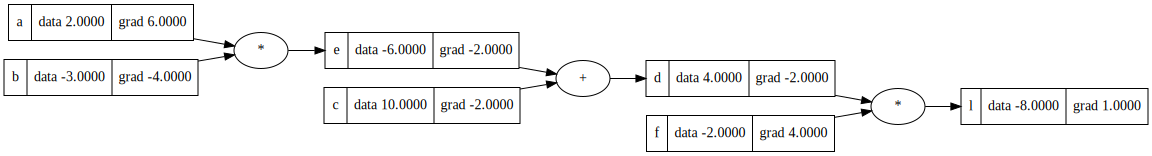

In [ ]:
draw_dot(L)

In [ ]:
def lol():
    h = 0.001
    a = Value(2.0,label="a")
    b = Value(-3.0,label="b")
    c= Value(10.0,label="c")
    # c.data += h
    e = a*b ; e.label="e"

    d = e + c ;d.label='d'
    f = Value(-2.0,label='f')
    L= d * f; L.label='l'
    L1 = L.data

    a = Value(2.0,label="a")
    b = Value(-3.0,label="b")
    b.data += h
    c= Value(10.0,label="c")
    e = a*b ; e.label="e"

    d = e + c ;d.label='d'
    f = Value(-2.0,label='f')
    L= d * f; L.label='l'
    L2 = L.data
    print((L2 - L1)/h)

lol()

-3.9999999999995595


In [ ]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a *b
d = e + c
L = d * f
L.data

-7.286496

In [ ]:
def relu(x):
    return np.maximum(0,x)
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


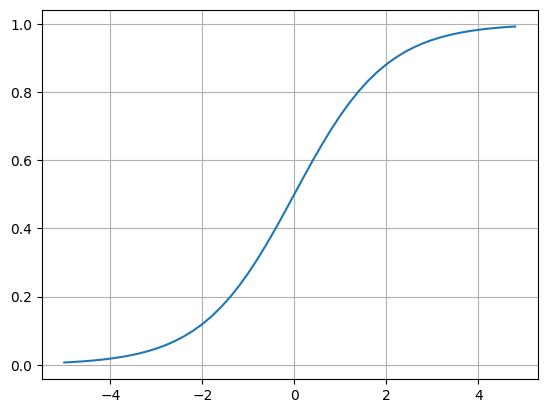

In [ ]:
x = np.arange(-5,5,0.2)
y = sigmoid(x)
plt.plot(x,y)
plt.grid()

In [ ]:
#inputs
x1 = Value(2.0,label = 'x1')
x2 = Value(0.0,label = 'x2')
#weights
w1 = Value(-3.0,label = "w1")
w2 = Value(1.0,label = 'w2')
#bias
b = Value(6.8813735870195432,label = 'b')

x1w1 = x1*w1 ; x1w1.label = 'x1*w1'
x2w2 = x2*w2 ; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2 ; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b ;n.label ='n'
o = n.tanh(); o.label

''

In [ ]:
# o.grad = 1
# n.grad = 0.5
# x1w1x2w2.grad = 0.5
# b.grad = 0.5
# x1w1.grad = 0.5
# x2w2.grad = 0.5
# x2.grad = w2.data * x2w2.grad
# w2.grad = x2.data * x2w2.grad
# w1.grad  = x1.data * x1w1.grad
# x1.grad = w1.data * x1w1.grad

# o.grad = 1
# o._backward()
# n._backward()
# x1w1x2w2._backward()
# x1w1._backward()
# x2w2._backward()

In [ ]:
# o.grad = 1
# visited = set()
# topo = []
# def build_topo(v):
#     if v not in visited:
#         visited.add(v)
#         for child in v._prev:
#             build_topo(child)
#         topo.append(v)
# build_topo(o)

# for node in reversed(topo):
#     node._backward()

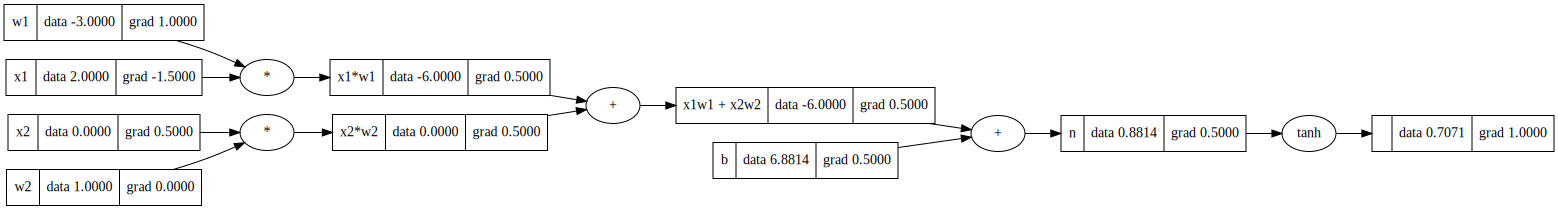

In [ ]:
o.backward()
draw_dot(o)

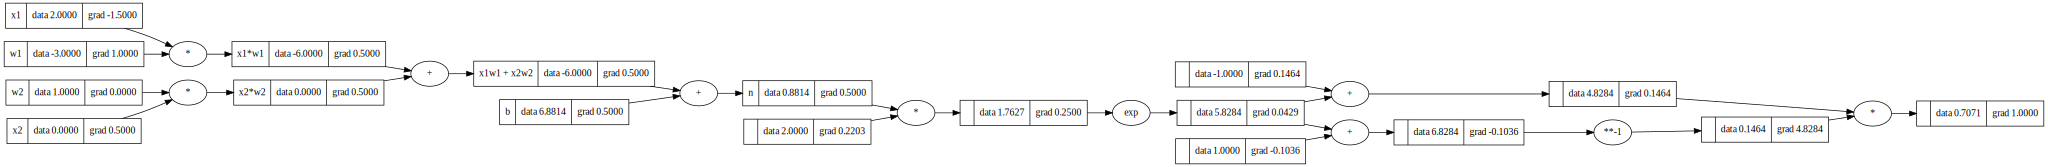

In [ ]:
#inputs
x1 = Value(2.0,label = 'x1')
x2 = Value(0.0,label = 'x2')
#weights
w1 = Value(-3.0,label = "w1")
w2 = Value(1.0,label = 'w2')
#bias
b = Value(6.8813735870195432,label = 'b')

x1w1 = x1*w1 ; x1w1.label = 'x1*w1'
x2w2 = x2*w2 ; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2 ; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b ;n.label ='n'
e = (2*n).exp()
o = (e - 1) / (e + 1); o.label
o.backward()
draw_dot(o)

In [ ]:
import torch

In [ ]:
x1 = torch.Tensor([2.0]).double()                   ;x1.requires_grad_(True)
x2 = torch.Tensor([0.0]).double()                   ;x2.requires_grad_(True)
w1 = torch.Tensor([-3.0]).double()                  ;w1.requires_grad_(True)
w2 = torch.Tensor([1.0]).double()                   ;w2.requires_grad_(True)
b = torch.Tensor([6.8813735870195432]).double()     ;b.requires_grad_(True)

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()
print('--------')
print('x2',x2.grad.item())
print('w2',w2.grad.item())
print('x1',x1.grad.item())
print('w1',w1.grad.item())

0.7071066904050358
--------
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [ ]:
class Neuron:
    def __init__(self,nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
    def __call__(self,x):
        #w*x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    def parameters(self):
        return self.w + [self.b]

In [ ]:
x = [2.0,3.0]
neuron = Neuron(2)
neuron(x)

Value(data=0.8181622318511568)

In [ ]:
class Layer:
    def __init__(self,nin,nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self,x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        # params = []
        # for neuron in self.neurons:
        #     ps = neuron.parameters()
        #     params.extend(ps)
        # return params
x = [2.0,3.0]
n = Layer(2,4)
n(x)

[Value(data=-0.9996612851946786),
 Value(data=-0.008835974422672857),
 Value(data=0.02193028784387421),
 Value(data=0.7914636335544163)]

In [ ]:
class MLP:
    def __init__(self,nin,nouts):
        sz = [nin] + nouts

        self.layers = [Layer(sz[i],sz[i+1]) for i in range(len(nouts))]
    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        return x
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [ ]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.34818180943760046)

In [ ]:
len(n.parameters())

41

In [ ]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
# y_pred = [n(x) for x in xs]
# y_pred

In [ ]:
for k in range(20):
    #forward pass
    y_pred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, y_pred))

    #backward pass
    for p in n.parameters():
        p.grad = 0
    loss.backward()

    #update
    for p in n.parameters():
        p.data += -0.1 * p.grad

    print(k,loss.data)


0 0.013554574357063708
1 0.013185155787227067
2 0.012833306555204408
3 0.01249784382073639
4 0.012177687431229104
5 0.011871849059396197
6 0.01157942268868773
7 0.011299576255510967
8 0.011031544287570087
9 0.010774621402653218
10 0.010528156552906264
11 0.010291547916847391
12 0.010064238355747374
13 0.00984571136303521
14 0.009635487445504477
15 0.009433120883627142
16 0.00923819682549731
17 0.009050328675052344
18 0.0088691557404301
19 0.008694341112770381


In [ ]:
y_pred

[Value(data=0.960479548323418),
 Value(data=-0.9409714948678864),
 Value(data=-0.9622292632885051),
 Value(data=0.9528673993695627)]